# Project Reviews Aggregator

## Import libraries

In [23]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer



## Data cleaning

### Load Kaggle data

In [24]:
# Loading data from kaggle

import kagglehub

# Download latest version
path_kaggle = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path_kaggle)

Path to dataset files: /root/.cache/kagglehub/datasets/datafiniti/consumer-reviews-of-amazon-products/versions/5


In [25]:
import pandas as pd
import os


# List all CSV files in the directory
csv_files = [file for file in os.listdir(path_kaggle) if file.endswith('.csv')]

# Iterate through each CSV file and print its headers
for file in csv_files:
    file_path = os.path.join(path_kaggle, file)
    df = pd.read_csv(file_path, low_memory=False)
    print(f"Headers for {file}:")
    for header in df.columns:
        print(header)
    print("\n" + "-" * 50 + "\n")  # Separator for better readability


Headers for Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv:
id
dateAdded
dateUpdated
name
asins
brand
categories
primaryCategories
imageURLs
keys
manufacturer
manufacturerNumber
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.username
sourceURLs

--------------------------------------------------

Headers for Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv:
id
dateAdded
dateUpdated
name
asins
brand
categories
primaryCategories
imageURLs
keys
manufacturer
manufacturerNumber
reviews.date
reviews.dateSeen
reviews.didPurchase
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.username
sourceURLs

--------------------------------------------------

Headers for 1429_1.csv:
id
name
asins
brand
categories
keys
manufacturer
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.didPu

In [26]:
######## Create Kaggle dataframe with the 3 review csv ########

# List all CSV files in the directory
csv_files = [file for file in os.listdir(path_kaggle) if file.endswith('.csv')]

# Combine all CSV files into a single DataFrame
dataframes = []
for file in csv_files:
    file_path = os.path.join(path_kaggle, file)
    df = pd.read_csv(file_path, low_memory=False)  # Prevent dtype warnings
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame, aligning columns
kag_comb = pd.concat(dataframes, ignore_index=True, sort=True)

# Define the project directory
project_dir = os.getcwd()  # Gets the current working directory

# Path to the "data" folder in the project directory
data_dir = os.path.join(project_dir, "data")

# Ensure the "data" folder exists
os.makedirs(data_dir, exist_ok=True)

# Save the combined DataFrame to a new CSV file in the "data" folder
kag_comb_path = os.path.join(data_dir, "kag_comb.csv")
kag_comb.to_csv(kag_comb_path, index=False)

print(f"Combined CSV saved to {kag_comb_path}")


######## Load generated CSV ########

kag_comb = pd.read_csv("data/kag_comb.csv")


Combined CSV saved to /content/data/kag_comb.csv


<ipython-input-26-2b1d6e65c5b2>:34: DtypeWarning: Columns (3,4,6,9,10,11,15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  kag_comb = pd.read_csv("data/kag_comb.csv")


### Clean Kaggle data

In [27]:
#Check df heads

# List of columns to drop
columns_to_drop = [
    'dateAdded',
    'dateUpdated',
    'reviews.didPurchase',
    'reviews.userCity',
    'reviews.userProvince',
    'asins',
    'imageURLs',
    'manufacturerNumber',
    'primaryCategories',
    'sourceURLs',
    'reviews.sourceURLs',
    'keys',
    'reviews.date',
    'reviews.dateAdded',
    'reviews.dateSeen',
    'reviews.numHelpful'
]

# Drop the columns from the dataframe
kag_comb = kag_comb.drop(columns=columns_to_drop)


# Get a list of all column headers
headers = kag_comb.columns.tolist()

# Display the headers
for header in headers:
    print(header)


brand
categories
id
manufacturer
name
reviews.doRecommend
reviews.id
reviews.rating
reviews.text
reviews.title
reviews.username


In [28]:
kag_comb.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,llyyue
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack


In [29]:
# Check for duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id' columns
duplicates = kag_comb.duplicated(subset=['reviews.text', 'reviews.username', 'reviews.id'])

# Count the number of duplicate rows
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id': {num_duplicates}")

# If you want to display the duplicate rows
if num_duplicates > 0:
    duplicate_rows = kag_comb[duplicates]
    print("Duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id':")
    print(duplicate_rows)


Number of duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id': 19898
Duplicate rows based on 'reviews.text', 'reviews.username', 'reviews.id':
             brand                                         categories  \
414         Amazon  Computers,Amazon Echo,Virtual Assistant Speake...   
550         Amazon  Computers,Amazon Echo,Virtual Assistant Speake...   
748         Amazon  Amazon Echo,Virtual Assistant Speakers,Electro...   
750         Amazon  Amazon Echo,Virtual Assistant Speakers,Electro...   
755         Amazon  Amazon Echo,Virtual Assistant Speakers,Electro...   
...            ...                                                ...   
62899  Amazon Echo  Featured Brands,Electronics,Amazon Devices,Hom...   
62900  Amazon Echo  Featured Brands,Electronics,Amazon Devices,Hom...   
62901  Amazon Echo  Featured Brands,Electronics,Amazon Devices,Hom...   
62902  Amazon Echo  Featured Brands,Electronics,Amazon Devices,Hom...   
62903  Amazon Echo  Featured Bran

In [30]:
# Create a new dataframe with duplicates removed based on 'reviews.text', 'reviews.username' and 'id'
kag_comb_clean = kag_comb.drop_duplicates(subset=['reviews.text', 'reviews.username', 'reviews.id'])

# Remove rows with NaN in 'reviews.rating'
kag_comb_clean = kag_comb_clean.dropna(subset=['reviews.rating'])

# Remove rows with NaN in 'reviews.title'
kag_comb_clean = kag_comb_clean.dropna(subset=['reviews.title'])

# Verify the new dataframe
print(f"New dataframe shape: {kag_comb_clean.shape}")


New dataframe shape: (48044, 11)


In [31]:
# Check for NaN values in the 'reviews.ratingtext' column
nan_reviews_ratingtext = kag_comb_clean['reviews.rating'].isna()

# Count the number of NaN values
num_nan_reviews_ratingtext = nan_reviews_ratingtext.sum()
print(f"Number of NaN values in 'reviews.rating': {num_nan_reviews_ratingtext}")

# Display rows with NaN values in 'reviews.ratingtext'
if num_nan_reviews_ratingtext > 0:
    rows_with_nan = kag_comb_clean[nan_reviews_ratingtext]
    print("Rows with NaN in 'reviews.rating':")
    print(rows_with_nan)

Number of NaN values in 'reviews.rating': 0


### Add missing data for classification training

In [32]:
# Fill NaN values in 'reviews.doRecommend' based on 'reviews.rating'
kag_comb_clean['reviews.doRecommend'] = kag_comb_clean['reviews.doRecommend'].fillna(
    kag_comb_clean['reviews.rating'] > 3
)

# Verify the changes
print(kag_comb_clean['reviews.doRecommend'].isna().sum())

0


<ipython-input-32-c232e0b790f0>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kag_comb_clean['reviews.doRecommend'] = kag_comb_clean['reviews.doRecommend'].fillna(


In [33]:
# Check for NaN values in the 'reviews.doRecommend' column
nan_reviews_text = kag_comb_clean['reviews.doRecommend'].isna()

# Count the number of NaN values
num_nan_reviews_text = nan_reviews_text.sum()
print(f"Number of NaN values in 'reviews.doRecommend': {num_nan_reviews_text}")

# Display rows with NaN values in 'reviews.text'
if num_nan_reviews_text > 0:
    rows_with_nan = kag_comb_clean[nan_reviews_text]
    print("Rows with NaN in 'reviews.doRecommend':")
    print(rows_with_nan)

Number of NaN values in 'reviews.doRecommend': 0


## Preprocessing for sentiment training

### Adding sentiment traning targets

In [34]:
def classify_sentiment(rating):
    if rating <= 2:
        return "NEG"
    elif rating == 3:
        return "NEU"
    else:
        return "POS"

kag_comb_clean['sentiment'] = kag_comb_clean['reviews.rating'].apply(classify_sentiment)

kag_comb_clean.head()

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,llyyue,NEU
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,POS
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,POS
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,POS
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,POS


### Split into test & check

In [35]:
# FEATURES AND TARGET DEFINITION

# Features
X = kag_comb_clean[['reviews.text', 'reviews.title']]
## X = kag_comb_clean['combined_reviews']


# Targets
y_sentiment = kag_comb_clean['sentiment']  # For sentiment analysis
y_recommend = kag_comb_clean['reviews.doRecommend']  # For recommendation prediction

### Functions for text cleaning

In [36]:
# Clean text for titles and comments function

import re

def clean_artefacts(sentence):
    """
    Cleans a single sentence by removing unnecessary artefacts and characters while preserving sentiment-relevant information.
    """
    if not isinstance(sentence, str):
        sentence = str(sentence)  # Ensure input is a string

    # Remove JS/CSS
    sentence = re.sub(
        r'<script\b[^<]*(?:(?!<\/script>)<[^<]*)*<\/script>|<style\b[^<]*(?:(?!<\/style>)<[^<]*)*<\/style>',
        '',
        sentence,
    )

    # Remove HTML comments
    sentence = re.sub(r'<!--.*?-->', '', sentence)

    # Remove HTML tags, keeping their content
    sentence = re.sub(r'<[^>]+>', '', sentence)

    # Retain numbers but normalize by spacing (optional, depending on dataset needs)
    sentence = re.sub(r'(\d+)', r' \1 ', sentence)

    # Preserve single-character words like 'I' and sentiment-rich punctuation
    # Remove non-alphanumeric characters except common sentiment symbols
    sentence = re.sub(r'[^a-zA-Z0-9\s.,!?$€£\'":;#@%&*\(\)\[\]\-+=_/]', ' ', sentence)

    # Substitute multiple spaces with a single space
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    # Convert to lowercase
    sentence = sentence.lower()

    return sentence



In [37]:
# clean title and text and add them to new columns

kag_comb_clean['clean title'] = kag_comb_clean['reviews.title'].apply(clean_artefacts)
kag_comb_clean['clean review'] = kag_comb_clean['reviews.text'].apply(clean_artefacts)

## Adding PySentimiento for sentiment analysis

In [38]:
!pip install transformers
!pip install pysentimiento[transformers]

In [39]:
from pysentimiento import create_analyzer
import torch

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the analyzer
analyzer = create_analyzer(task="sentiment", lang="en")

# Move the model to GPU
analyzer.model.to(device)

# Function to classify sentiment
def classify_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or non-string values gracefully

    result = analyzer.predict(text)  # Use pysentimiento to analyze sentiment
    return result.output  # Return the sentiment label (e.g., "positive", "neutral", "negative")

# Apply sentiment analysis to the 'clean title' and 'clean review' columns
kag_comb_clean['title sentiment'] = kag_comb_clean['clean title'].apply(classify_sentiment)
kag_comb_clean['review sentiment'] = kag_comb_clean['clean review'].apply(classify_sentiment)

# Function to classify sentiment with scores
def classify_sentiment_with_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or non-string values gracefully

    result = analyzer.predict(text)
    return {
        "label": result.output,  # Sentiment label
        "probas": result.probas  # Probability scores
    }

# Apply sentiment analysis with scores to the columns
kag_comb_clean['title sentiment details'] = kag_comb_clean['clean title'].apply(classify_sentiment_with_scores)
kag_comb_clean['review sentiment details'] = kag_comb_clean['clean review'].apply(classify_sentiment_with_scores)

# Function to merge probabilities
def merge_probabilities(row):
    if row['title sentiment details'] and row['review sentiment details']:
        title_probas = row['title sentiment details']['probas']
        review_probas = row['review sentiment details']['probas']
        # Average the probabilities
        combined_probas = {k: (title_probas[k] + review_probas[k]) / 2 for k in title_probas}
        # Return the label with the highest combined probability
        return max(combined_probas, key=combined_probas.get)
    elif row['title sentiment details']:
        return row['title sentiment details']['label']
    elif row['review sentiment details']:
        return row['review sentiment details']['label']
    return None  # Handle empty rows

# Merge the sentiment scores into a single column
kag_comb_clean['merged PySent sentiment'] = kag_comb_clean.apply(merge_probabilities, axis=1)


In [40]:
kag_comb_clean.head(50)

,brand,categories,id,manufacturer,name,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.username,sentiment,clean title,clean review,title sentiment,review sentiment,title sentiment details,review sentiment details,merged PySent sentiment
0,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,3.0,I thought it would be as big as small paper bu...,Too small,llyyue,NEU,too small,i thought it would be as big as small paper bu...,NEU,NEG,"{'label': 'NEU', 'probas': {'NEG': 0.214903503...","{'label': 'NEG', 'probas': {'NEG': 0.880224943...",NEG
1,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,POS,great light reader. easy to use at the beach,this kindle is light and easy to use especiall...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001225944...","{'label': 'POS', 'probas': {'NEG': 0.001145137...",POS
2,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,4.0,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,POS,great for the price,didnt know how much i'd use a kindle so went f...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.022799693...","{'label': 'POS', 'probas': {'NEG': 0.002035730...",POS
3,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,177283626.0,5.0,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,POS,a great buy,i am 100 happy with my purchase. i caught it o...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.002319600...","{'label': 'POS', 'probas': {'NEG': 0.002211279...",POS
4,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,POS,solid entry-level kindle. great for kids,solid entry level kindle. great for kids. gift...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.001506322...","{'label': 'POS', 'probas': {'NEG': 0.001497109...",POS
5,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,5.0,This make an excellent ebook reader. Don't exp...,Good ebook,rmwarriors,POS,good ebook,this make an excellent ebook reader. don't exp...,POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.002107313...","{'label': 'POS', 'probas': {'NEG': 0.001685527...",POS
6,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,187043823.0,5.0,"I ordered this for my daughter, as I have the ...",Light Weight - Makes a world of difference whe...,LexieCrews,POS,light weight - makes a world of difference whe...,"i ordered this for my daughter, as i have the ...",POS,POS,"{'label': 'POS', 'probas': {'NEG': 0.003771256...","{'label': 'POS', 'probas': {'NEG': 0.001397100...",POS
7,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",False,NaN,4.0,I bought my Kindle about 2 months ago and the ...,not good quality,merry,POS,not good quality,i bought my kindle about 2 months ago and the ...,NEG,NEG,"{'label': 'NEG', 'probas': {'NEG': 0.969674885...","{'label': 'NEG', 'probas': {'NEG': 0.947255671...",NEG
8,Amazon,"Computers,Electronics Features,Tablets,Electro...",AVqVGZNvQMlgsOJE6eUY,Amazon,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",True,NaN,5.0,"amazon kindle is always the best ebook, upgrad...",best ebook,ST

## Evaluate PySentimiento

In [52]:
# Compare ground-truth and predicted sentiment
kag_comb_clean['PySent correct'] = kag_comb_clean['sentiment'] == kag_comb_clean['merged PySent sentiment']

In [53]:
pysent_accuracy = kag_comb_clean['PySent correct'].mean()
print(f"PySent Accuracy: {pysent_accuracy:.2%}")

PySent Accuracy: 90.45%


Confusion Matrix:


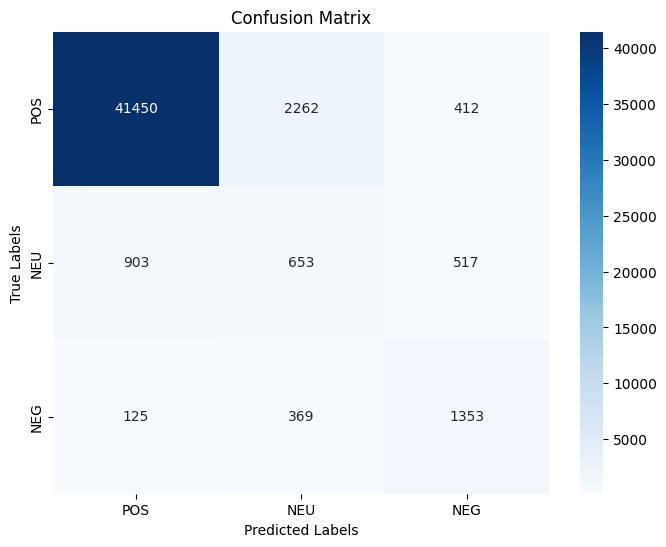

In [46]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get ground truth and predictions
y_true = kag_comb_clean['sentiment']
y_pred = kag_comb_clean['merged PySent sentiment']

# Generate confusion matrix
labels = ['POS', 'NEU', 'NEG']  # Replace with the actual labels used in your dataset
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Print confusion matrix
print("Confusion Matrix:")

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [47]:
from sklearn.metrics import classification_report, accuracy_score

# Generate classification report
report = classification_report(y_true, y_pred, labels=['POS', 'NEU', 'NEG'], target_names=['Positive', 'Neutral', 'Negative'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print the classification report and accuracy
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2%}")


Classification Report:
              precision    recall  f1-score   support

    Positive       0.98      0.94      0.96     44124
     Neutral       0.20      0.32      0.24      2073
    Negative       0.59      0.73      0.66      1847

    accuracy                           0.90     48044
   macro avg       0.59      0.66      0.62     48044
weighted avg       0.93      0.90      0.91     48044

Accuracy: 90.45%


In [55]:
# prompt: I want to save kag_comb_clean as a csv

# Assuming kag_comb_clean is already defined as in your provided code

# Save the DataFrame to a CSV file
kag_comb_clean.to_csv('kag_comb_clean_PySentimiento.csv', index=False)